<a href="https://colab.research.google.com/github/Juliodominguezcalderon/proyecto/blob/main/Proyecto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

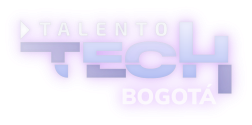

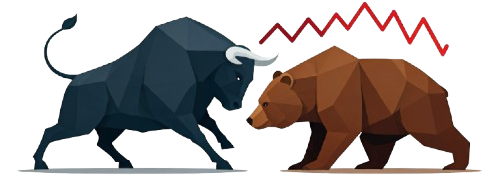

# Importamos las librerias a utilizar

In [4]:
#!pip install pmdarima
#!pip install seasonal

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 29.1 MB/s eta 0:00:00


In [12]:
import yfinance as yf
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm
import numpy as np

from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima
from seasonal import seasonal
from sklearn.ensemble import RandomForestRegressor
from prophet import Prophet

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

In [13]:
acciones = ["AAPL", "MSFT", "GOOG", "NVDA"]
#acciones = ["AAPL"]
inicio = "2005-01-01"
fin = datetime.today().strftime('%Y-%m-%d') #Establecemos como fecha de final para descargar los datos a la fecha de hoy.

# Descargar datos históricos
datos_historicos = []
consolidado_acciones = []
hist_por_accion = []

for accion in acciones:
    hist_por_accion = yf.download(accion, start=inicio, end=fin)
    hist_por_accion.columns = hist_por_accion.columns.get_level_values('Price')# Nos quedamos con las columnas del nivel Price de los 2 niveles de los datos obtenidos
    #hist_por_accion.columns = ["_".join(col).strip() if isinstance(col, tuple) else col for col in hist_por_accion.columns] #Esta línea convierte el MultiIndex en nombres de columna de una sola línea
    hist_por_accion = hist_por_accion.reset_index()  # Restablece el índice
    hist_por_accion["Simbolo"] = accion #Incluimos la columna acción
    datos_historicos.append(hist_por_accion)

consolidado_acciones = pd.concat(datos_historicos, ignore_index=True)
consolidado_acciones = pd.DataFrame(consolidado_acciones)
consolidado_acciones['Date'] = pd.to_datetime(consolidado_acciones['Date']).dt.date # Nos quedamos con el formato año-mes-día
consolidado_acciones['Date'] = pd.to_datetime(consolidado_acciones['Date'])

#Segmentamos el dataframe por trimestres, mes y semana
consolidado_acciones["Año"] = pd.DatetimeIndex(consolidado_acciones['Date']).year
consolidado_acciones["Trim"] = pd.DatetimeIndex(consolidado_acciones['Date']).quarter
consolidado_acciones["Mes"] = pd.DatetimeIndex(consolidado_acciones['Date']).month

# Renombramos las columnas
consolidado_acciones = consolidado_acciones.rename(columns={
    'Date': 'Fecha',
    'Open': 'Apertura',
    'High': 'Máximo',
    'Low': 'Mínimo',
    'Close': 'Cierre',
    'Adj Close': 'Cierre Ajustado',
    'Volume': 'Volumen'
})

consolidado_acciones = consolidado_acciones.set_index('Fecha')


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [14]:
# Visualizamos el historico de precios
fig = px.line(consolidado_acciones, x=consolidado_acciones.index, y="Cierre Ajustado", color="Simbolo", title='Precio de Cierre de Acciones',template='plotly_dark')
fig.update_xaxes(title_text='Fecha')
fig.update_yaxes(title_text='Precio de Cierre ajustado')
fig.show()

In [15]:
# Aplicamos la prueba de ADF sobre la serie logarítmica para cada acción
for accion in acciones:
    print(f"Prueba Dickey-Fuller ADF para la acción {accion} en Serie Logarítmica:")

    # Filtrar los datos para cada acción
    datos_accion = consolidado_acciones[consolidado_acciones['Simbolo'] == accion]

    # Calcular el logaritmo del precio de cierre
    serie_log = np.log(datos_accion['Cierre Ajustado'])

    # Aplicar la prueba ADF en la serie logarítmica
    resultado_adf_log = adfuller(serie_log.dropna())

    # Imprimir los resultados
    print(f"Estadístico ADF: {resultado_adf_log[0]}")
    P_valor = 0.05
    if resultado_adf_log[1] <= P_valor:
        print("Se rechaza la hipótesis nula. La serie es estacionaria.")
    else:
        print("No se rechaza la hipótesis nula. La serie no es estacionaria.")
    print(f"p-valor: {resultado_adf_log[1]}")
    print(":" * 80)

Prueba Dickey-Fuller ADF para la acción AAPL en Serie Logarítmica:
Estadístico ADF: -1.201378427655353
No se rechaza la hipótesis nula. La serie no es estacionaria.
p-valor: 0.6730024662408657
::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Prueba Dickey-Fuller ADF para la acción MSFT en Serie Logarítmica:
Estadístico ADF: 1.043773771390848
No se rechaza la hipótesis nula. La serie no es estacionaria.
p-valor: 0.9947069983434127
::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Prueba Dickey-Fuller ADF para la acción GOOG en Serie Logarítmica:
Estadístico ADF: -0.7534582026148121
No se rechaza la hipótesis nula. La serie no es estacionaria.
p-valor: 0.8324127049259437
::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Prueba Dickey-Fuller ADF para la acción NVDA en Serie Logarítmica:
Estadístico ADF: 1.247180863666954
No se rechaza la hipótesis nula. La serie no es estacionaria.
p-valor: 0.996

In [16]:
# Realizmaos ADF sobre la serie logarítmica diferenciada para cada acción
for accion in acciones:
    print(f"Prueba Dickey-Fuller ADF para la acción {accion} en Serie Logarítmica Diferenciada:")

    # Filtrar los datos para cada acción
    datos_accion = consolidado_acciones[consolidado_acciones['Simbolo'] == accion]

    # Calcular el logaritmo del precio de cierre Ajustado
    serie_log = np.log(datos_accion['Cierre Ajustado'])

    # Diferenciación de la serie logarítmica (primer diferencia)
    serie_log_diff = serie_log.diff().dropna()

    # Aplicar la prueba ADF en la serie logarítmica diferenciada
    resultado_adf_log_diff = adfuller(serie_log_diff)

    # Imprimir los resultados
    print(f"Estadístico ADF: {resultado_adf_log_diff[0]}")
    P_valor = 0.05
    if resultado_adf_log_diff[1] <= P_valor:
        print("Se rechaza la hipótesis nula para el diferencial. La serie es estacionaria.")
    else:
        print("No se rechaza la hipótesis nula para el diferencial. La serie no es estacionaria.")
    print(f"p-valor: {resultado_adf_log_diff[1]}")
    print(":" * 80)

Prueba Dickey-Fuller ADF para la acción AAPL en Serie Logarítmica Diferenciada:
Estadístico ADF: -16.68963451761437
Se rechaza la hipótesis nula para el diferencial. La serie es estacionaria.
p-valor: 1.4922995593660896e-29
::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Prueba Dickey-Fuller ADF para la acción MSFT en Serie Logarítmica Diferenciada:
Estadístico ADF: -25.468498239903177
Se rechaza la hipótesis nula para el diferencial. La serie es estacionaria.
p-valor: 0.0
::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Prueba Dickey-Fuller ADF para la acción GOOG en Serie Logarítmica Diferenciada:
Estadístico ADF: -72.74398540447768
Se rechaza la hipótesis nula para el diferencial. La serie es estacionaria.
p-valor: 0.0
::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Prueba Dickey-Fuller ADF para la acción NVDA en Serie Logarítmica Diferenciada:
Estadístico ADF: -14.245800136253129
Se re

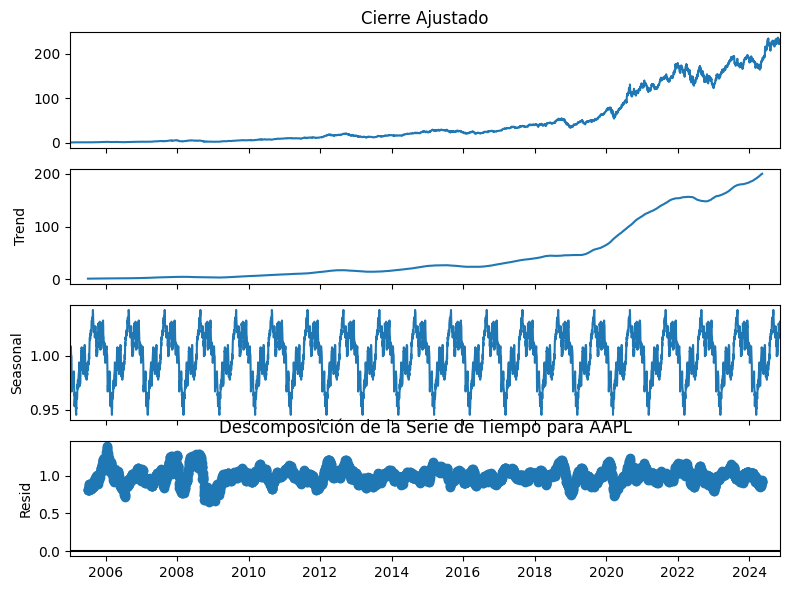

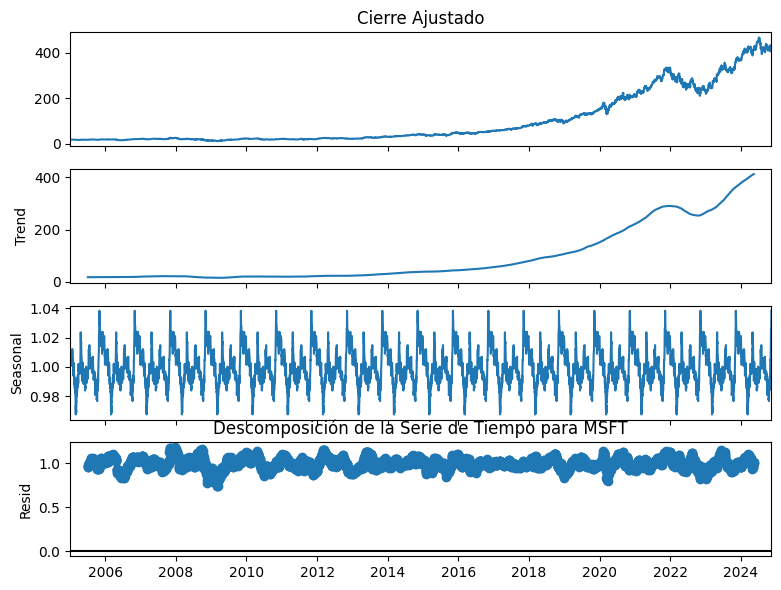

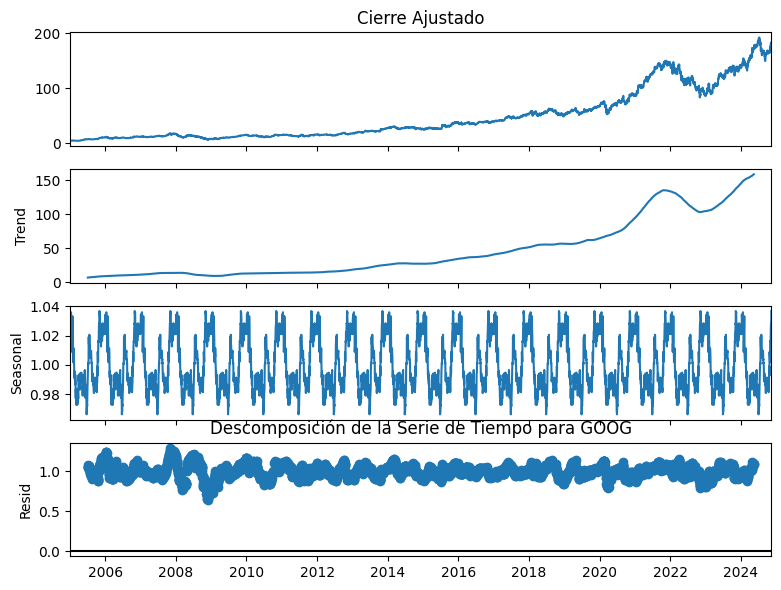

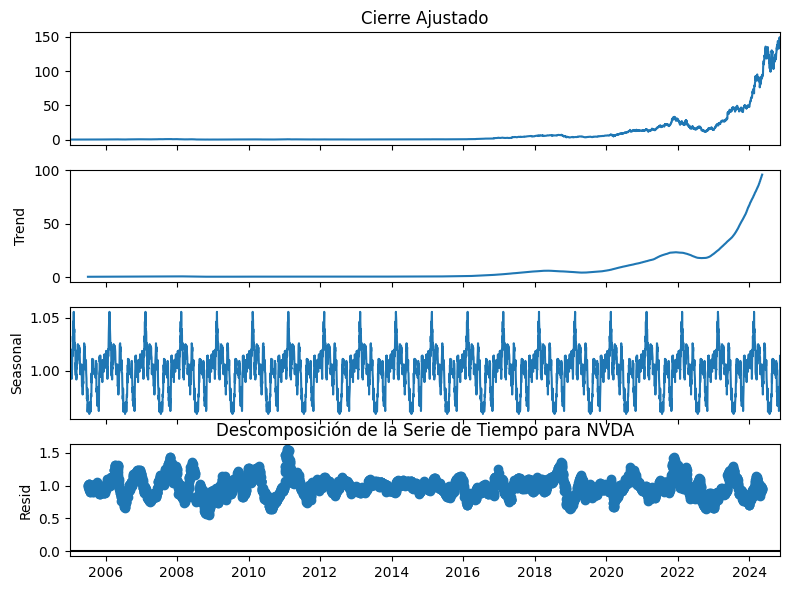

In [17]:
# Descomposición de la serie de tiempo para cada acción

for accion in acciones:
  datos_accion = consolidado_acciones[consolidado_acciones['Simbolo'] == accion]['Cierre Ajustado']
  result = seasonal_decompose(datos_accion, model='mult', period=252) # Días hábiles

  # Graficar la descomposición
  plt.rcParams.update({'figure.figsize': (8, 6)})
  result.plot()
  plt.title(f"Descomposición de la Serie de Tiempo para {accion}")  # Agregar título con el nombre de la acción
  plt.show()

In [ ]:
#Definimos las función para obtener los componentes para las acciones para gráfica en power bi
#Inicio--->
def obtener_componentes_series_tiempo(df):
  df_componentes = pd.DataFrame()
  for accion in df['Simbolo'].unique():
    df_accion = df[df['Simbolo'] == accion].copy()
    # Descomponemos de la serie de tiempo
    result = seasonal_decompose(df_accion['Cierre Ajustado'], model='mult', period=252) # Corresponde a la cantidad de días hábiles
    df_accion['Tendencia'] = result.trend #Obtenemos los valores de tendencia.
    df_accion['Estacionalidad'] = result.seasonal #Obtenemos los valores de estacionalidad
    df_accion['Residuo'] = result.resid #Obtenemos los valores de estacionalidad
    df_componentes = pd.concat([df_componentes, df_accion])#Concatemas cada componente obtenida
  return df_componentes
#Integramos los valores de las componentes al dataframde de trabajo
consolidado_acciones = obtener_componentes_series_tiempo(consolidado_acciones)
#---> Fin

In [23]:
#Opciona para ver el compartamiento de la serie de tiempo de forma mensual o trimestral
consolidado_acciones['Fecha2'] = consolidado_acciones.index #creamos una copia de fecha para usarla en estas graficas
consolidado_acciones['Cierre ajustado mensual'] = consolidado_acciones.groupby(['Simbolo', pd.Grouper(key='Fecha2', freq='MS')])['Cierre Ajustado'].transform('last')
consolidado_acciones['Cierre ajustado trimestral'] = consolidado_acciones.groupby(['Simbolo', pd.Grouper(key='Fecha2', freq='QS')])['Cierre Ajustado'].transform('last')

consolidado_acciones_mensual = consolidado_acciones[['Fecha2','Simbolo','Cierre ajustado mensual']].drop_duplicates()
consolidado_acciones_mensual = consolidado_acciones_mensual.sort_values(['Simbolo','Fecha2'])

consolidado_acciones_trimestral = consolidado_acciones[['Fecha2','Simbolo','Cierre ajustado trimestral']].drop_duplicates()
consolidado_acciones_trimestral = consolidado_acciones_trimestral.sort_values(['Simbolo','Fecha2'])

# Visualizamos el historico de precios mensual
fig = px.line(consolidado_acciones_mensual, x=consolidado_acciones.index, y="Cierre ajustado mensual", color="Simbolo", title='Precio de Cierre de Acciones Ajustado Mensual',template='plotly_dark')
fig.update_xaxes(title_text='Fecha')
fig.update_yaxes(title_text='Precio de Cierre ajustado mensual')
fig.show()

fig1 = px.line(consolidado_acciones_trimestral, x=consolidado_acciones.index, y="Cierre ajustado trimestral", color="Simbolo", title='Precio de Cierre de Acciones Ajustado trimestral',template='plotly_dark')
fig1.update_xaxes(title_text='Fecha')
fig1.update_yaxes(title_text='Precio de Cierre ajustado trimestral')
fig1.show()

consolidado_acciones = consolidado_acciones.drop(columns=['Fecha2']) #Eliminamos la columna creada para esta visual


In [ ]:
#Evaluación de modelos

import numpy as np
from sklearn import metrics
from sklearn.metrics import r2_score
def evaluacion_modelo(y_true, y_pred):

    def men_abs_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) *100
    #print('Evaluación del modelo: \n')
    print('MSE = ', metrics.mean_squared_error(y_true, y_pred))
    print('MAE = ', metrics.mean_absolute_error(y_true, y_pred))
    print('RMSE =', np.sqrt(metrics.mean_squared_error(y_true, y_pred)))
    print('MAPE = ', men_abs_percentage_error(y_true, y_pred))
    print(f'R2 = {r2_score(y_true, y_pred)}')

# **Modelos de predicción**

## Modelo SARIMAX

In [ ]:
# Datos generales para la división en entrenamiento y prueba
fecha_limite = pd.to_datetime('2023-12-31')
train_data_mask = consolidado_acciones.index <= fecha_limite
longitud_train_data = train_data_mask.sum()
longitud_test_data = len(consolidado_acciones) - longitud_train_data
total_data = len(consolidado_acciones)
tamaño = longitud_test_data / total_data

total_data, train_data, test_data, tamaño

(19996, 4781, 218, 0.04360872174434887)

In [ ]:
from statsmodels.tsa.stattools import adfuller

resultados_sarimax_por_accion = {}
añadir_resultados_sarimax_por_accion =[]
Resultados_SA = {}

acciones = ["AAPL","MSFT","GOOG","NVDA"]

for accion in acciones:
    print(f"Ajustando modelo SARIMAX para la acción: {accion}")
    datos_accion = consolidado_acciones[consolidado_acciones['Simbolo'] == accion]
    datos_accion = datos_accion['Cierre Ajustado']

    train_data_SA, test_data_SA = train_test_split(datos_accion, test_size=tamaño, random_state=42, shuffle=False) # El argumento shuffle=False asegura que la división se realice de manera secuencial sin revolver los datos.
    train_data_SA = pd.DataFrame(train_data_SA)
    test_data_SA = pd.DataFrame(test_data_SA)
    print(train_data_SA.shape, test_data_SA.shape)
    #print(f"Tamaño de datos de entrenamiento: {len(train_data_SA)} <--> {len(train_data_SA)*100/len(datos_accion):.0f} %")
    #print(f"Tamaño de datos de prueba       : {len(test_data_SA)} <--> {len(test_data_SA)*100/len(datos_accion):.0f} %\n")

    #adf_result = adfuller(datos_accion)

    #print(f'p-value: {adf_result[1]}')

    # Ajustar el modelo ARIMA automático
    modelo_auto = pm.auto_arima(train_data_SA, start_p=0, q=0,
                          test='adf',       # Ajusta el mejor valor para d aplicando la prueba Augmented Dickey Fuller
                          max_p=3, max_q=3, # maximos valores para p y q
                          m=1,                            # Días hábiles
                          d=None,                         # El modelo determina el valor de d
                          seasonal=False,                 # Serie de tiempo no estacional de acuerdo con la prueba ADF
                          start_P=0, start_Q=0,           # Iniciar en 0 para la estacionalidad
                          max_P=2, max_Q=2,               # Límite en el orden AR y MA estacionales
                          D=1,                            # Diferenciación estacional
                          max_order=10,                   # Límite en el orden total
                          stepwise=True,                  # Búsqueda rápida en lugar de exhaustiva
                          error_action="ignore",          # Ignorar errores menores
                          suppress_warnings=True,         # Suprimir advertencias
                          trace=False)                    # Mostrar detalles del ajuste

    # Obtener los mejores parámetros del modelo
    order = modelo_auto.order
    seasonal_order = modelo_auto.seasonal_order

    # Ajustar el modelo con los mejores parámetros
    sarimax_model = SARIMAX(train_data_SA, order=order, seasonal_order=seasonal_order).fit()

    #Realizamos las predicciones
    #resultados_sarimax_por_accion = sarimax_model.predict(start= train_data, end = len(datos_accion)-1).rename('SA_predicción')
    resultados_sarimax_por_accion = sarimax_model.predict(start = train_data_SA, end = len(datos_accion)-1, typ='levels').rename('SA_predicción')
    resultados_sarimax_por_accion = pd.DataFrame(resultados_sarimax_por_accion)
    resultados_sarimax_por_accion['Simbolo'] = accion
    resultados_sarimax_por_accion.index = test_data_SA.index
    añadir_resultados_sarimax_por_accion.append(resultados_sarimax_por_accion)

Resultados_SA = pd.concat(añadir_resultados_sarimax_por_accion)
Resultados_SA = pd.DataFrame(Resultados_SA)
Resultados_SA.to_csv('Resultados_SA_2.csv')

Ajustando modelo SARIMAX para la acción: AAPL
(4781, 1) (218, 1)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/

Ajustando modelo SARIMAX para la acción: MSFT
(4781, 1) (218, 1)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python

Ajustando modelo SARIMAX para la acción: GOOG
(4781, 1) (218, 1)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/

Ajustando modelo SARIMAX para la acción: NVDA
(4781, 1) (218, 1)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/

In [ ]:
#datos_historicos = []
consolidado_acciones = []
#hist_por_accion = []

for accion in acciones:
    hist_por_accion = yf.download(accion, start=inicio, end=fin)
    hist_por_accion.columns = hist_por_accion.columns.get_level_values('Price')# Nos quedamos con las columnas del nivel Price de los 2 niveles de los datos obtenidos
    #hist_por_accion.columns = ["_".join(col).strip() if isinstance(col, tuple) else col for col in hist_por_accion.columns] #Esta línea convierte el MultiIndex en nombres de columna de una sola línea
    hist_por_accion = hist_por_accion.reset_index()  # Restablece el índice
    hist_por_accion["Simbolo"] = accion #Incluimos la columna acción
    datos_historicos.append(hist_por_accion)

consolidado_acciones = pd.concat(datos_historicos, ignore_index=True)
consolidado_acciones = pd.DataFrame(consolidado_acciones)

In [ ]:
for accion in acciones:
  print(f"Ajustando modelo SARIMAX para {accion}")
  datos_accion = consolidado_acciones[consolidado_acciones['Simbolo'] == accion]['Cierre Ajustado']

train_data, test_data = train_test_split(datos_accion[['Cierre Ajustado']], test_size=0.05, random_state=42, shuffle=False) # El argumento shuffle=False asegura que la división se realice de manera secuencial sin revolver los datos.


# Ajustar el modelo ARIMA automático
model_auto = pm.auto_arima(train_data_dias, start_p=0, q=0,
                      test='adf',       # Ajusta el mejor valor para d aplicando la prueba Augmented Dickey Fuller
                      max_p=3, max_q=3, # maximos valores para p y q
                      m=252,            # Frecuencia de la serie de tiempo
                      d=None,           # El modelo determina d
                      seasonal=False,   # Serie de tiempo no estacional
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

# Imprimir el resumen del modelo
print(model_auto.summary())

In [ ]:
bd_modelos = consolidado_acciones.copy()
bd_modelos = bd_modelos[bd_modelos['Simbolo'] == accion_a_filtrar]
bd_sarimax = bd_modelos.copy()

In [ ]:
accion_a_filtrar = "AAPL"  # Reemplaza con la acción que deseas filtrar ['AAPL', 'MSFT', 'GOOG', 'NVDA']

In [ ]:
# Dividir los datos en conjuntos de entrenamiento y prueba (95% entrenamiento, 5% prueba)
ventanas = 30

train_data_SA, test_data_SA = train_test_split(bd_sarimax[['Cierre Ajustado']],  test_size=0.05, random_state=42, shuffle=False) # El argumento shuffle=False asegura que la división se realice de manera secuencial sin revolver los datos.

train_data_dias = pd.DataFrame(train_data_SA)
test_data_dias = pd.DataFrame(test_data_SA)

print(f"Tamaño de datos de entrenamiento: {len(train_data_SA)} <--> {len(train_data_SA)*100/len(bd_sarimax):.0f} %")
print(f"Tamaño de datos de prueba: {len(test_data_SA)} <--> {len(test_data_SA)*100/len(bd_sarimax):.0f} %")

Tamaño de datos de entrenamiento: 4988 <--> 95 %
Tamaño de datos de prueba: 263 <--> 5 %


In [ ]:
# Ajustar el modelo ARIMA automático
model_auto = pm.auto_arima(train_data_dias, start_p=0, q=0,
                      test='adf',       # Ajusta el mejor valor para d aplicando la prueba Augmented Dickey Fuller
                      max_p=3, max_q=3, # maximos valores para p y q
                      m=252,            # Frecuencia de la serie correspondiente a días hábiles
                      d=None,           # El modelo determina d
                      seasonal=False,   # Serie de tiempo no estacional
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

# Imprimir el resumen del modelo
print(model_auto.summary())

In [ ]:
#Ejecutamos el modelo SARIMAX
sarimax_model = SARIMAX(train_data_dias, order=(2,1,2),seasonal_order=(0,0,0,0)).fit()

SA_predicción = sarimax_model.predict(start= len(train_data_SA), end = len(bd_sarimax)-1, typ='levels').rename('SA_predicción')
SA_predicción = pd.DataFrame(SA_predicción)
SA_predicción.index = test_data_SA.index

Resultado = test_data_dias.copy()
Resultado['SA_predicción'] = SA_predicción['SA_predicción']

In [ ]:
#Creamos el dataframe con los datos a visualizar
df_plot = pd.DataFrame({'Real': bd_sarimax['Cierre Ajustado'], 'SA_predicción': SA_predicción['SA_predicción']})

# Create the plot using Plotly Express
fig = px.line(df_plot, x=bd_sarimax.index, y=['Real','SA_predicción'], title='Predicciones vs. Datos Reales', template='plotly_dark') # Use df_plot.index for x
fig.update_xaxes(title_text='Fecha')
fig.update_yaxes(title_text='Precio de Cierre')
fig.show()

## **Modelo RANDOM FOREST**

In [ ]:
bd_random_forest = bd_modelos.copy()
bd_random_forest = pd.DataFrame(bd_random_forest['Cierre Ajustado'])

bd_random_forest['porcentaje_cambio'] = bd_random_forest['Cierre Ajustado'].pct_change()
bd_random_forest = bd_random_forest.dropna()

In [ ]:
# Estandarizamos el modelo
dias = 30 #Cantidad de dias de retraso
i = 1
# Generar datos retrasados para la columna 'Cierre Ajustado"
for i in range(1, dias):
    bd_random_forest[f'Close_lag_{i}'] = bd_random_forest['Cierre Ajustado'].shift(i)

bd_rf = bd_random_forest.dropna()

In [ ]:
#Modelación
X2 = bd_rf.iloc[:,2:]
y2 = bd_rf.iloc[:,1]

Y2 = y2
train_target_size = len(train_data_SA)-60
train_target, test_target = Y2[0:train_target_size], Y2[train_target_size:len(Y2)]

print(f"Observaciones para el objetivo:: {len(Y2)}")
print(f"Observaciones de entrenamiento para el objetivo: {len(train_target)}")
print(f"Observaciones de prueba para el objetivo: {len(test_target)}\n")

train_features_size = len(train_data_SA)-60
train_features, test_features = X2[:train_features_size], X2[train_features_size:len(X2)]
print(f'Observaciones para la característica: %d' % (len(X2)))
print(f"Observaciones de entrenamiento para la característica: %d" % (len(train_features)))
print(f"Observaciones de prueba para la característica: {len(test_features)}")

X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=210,  shuffle=False)

In [ ]:
#Ejecutamos la predicción con Random Forest
Semilla = 42

rfr = RandomForestRegressor(n_estimators=500, random_state=Semilla)

rfr.fit(train_features, train_target)

rf_forescast = rfr.predict(test_features)

In [ ]:
rf_forescast.shape

In [ ]:
pred_ramdom=np.r_[Resultado['Cierre Ajustado'].iloc[0],rf_forescast[1:]].cumsum().astype(float)
Resultado['RF_Predicciones'] = pred_ramdom

In [ ]:
fig = px.line(Resultado, x=Resultado.index, y=['Cierre Ajustado', 'SA_predicción','RF_Predicciones'],
             title='Comparación de Predicciones con Datos Reales (Test Data)', template='plotly_dark')
fig.update_xaxes(title_text='Fecha')
fig.update_yaxes(title_text='Precio de Cierre')
fig.show()

## **Modelo PROPHET**

In [ ]:
bd_prophet = bd_modelos['Cierre Ajustado']
bd_prophet = bd_prophet.reset_index()
bd_prophet = bd_prophet.rename(columns={'Fecha': 'ds', 'Cierre Ajustado': 'y'})

In [ ]:
test_Prophet = len(test_data_dias)
train_Prophet = len(bd_prophet)-test_Prophet
train_Prophet, test_Prophet

train_data_prophet = bd_prophet.iloc[:train_Prophet, :]
test_data_prophet = bd_prophet.iloc[train_Prophet:, :]
train_data_prophet.shape, test_data_prophet.shape

m = Prophet()
m.fit(train_data_prophet)

In [ ]:
future = m.make_future_dataframe(periods=len(test_data_prophet), freq='B')
prophet_pred = m.predict(future)
prophet_pred = pd.DataFrame({"Date":prophet_pred[-len(test_data_prophet):]["ds"], "Prophet_predicciones":prophet_pred[-len(test_data_prophet):]["yhat"]})
prophet_pred.set_index("Date", inplace=True)
Resultado['PP_predicciones'] = prophet_pred['Prophet_predicciones'].values

In [ ]:
Resultado.info()

In [ ]:
fig = px.line(Resultado, x=Resultado.index, y=['Cierre Ajustado', 'SA_predicción','PP_predicciones'],
             title='Comparación de Predicciones con Datos Reales (Test Data)', template='plotly_dark')
fig.update_xaxes(title_text='Fecha')
fig.update_yaxes(title_text='Precio de Cierre')
fig.show()

In [ ]:
fig = px.line(Resultado, x=Resultado.index, y=['Cierre Ajustado', 'SA_predicción','RF_Predicciones','PP_predicciones'],
             title='Comparación de Predicciones con Datos Reales (Test Data)', template='plotly_dark')
fig.update_xaxes(title_text='Fecha')
fig.update_yaxes(title_text='Precio de Cierre')
fig.show()

In [ ]:
print("Evaluación del modelo SARIMAX")
ev_SA = evaluacion_modelo(Resultado['Cierre Ajustado'], Resultado['SA_predicción'])

print("\nEvaluación del modelo RANDOM FOREST")
ev_RF = evaluacion_modelo(Resultado['Cierre Ajustado'], Resultado['RF_Predicciones'])

print("\nEvaluación del modelo PROPHET")
ev_PP = evaluacion_modelo(Resultado['Cierre Ajustado'], Resultado['PP_predicciones'])